## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [66]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [67]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

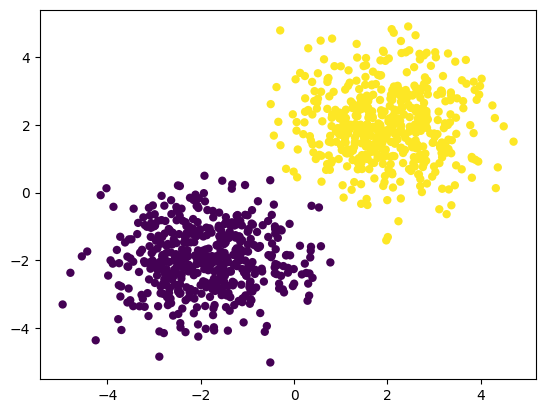

In [68]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [69]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [70]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [71]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

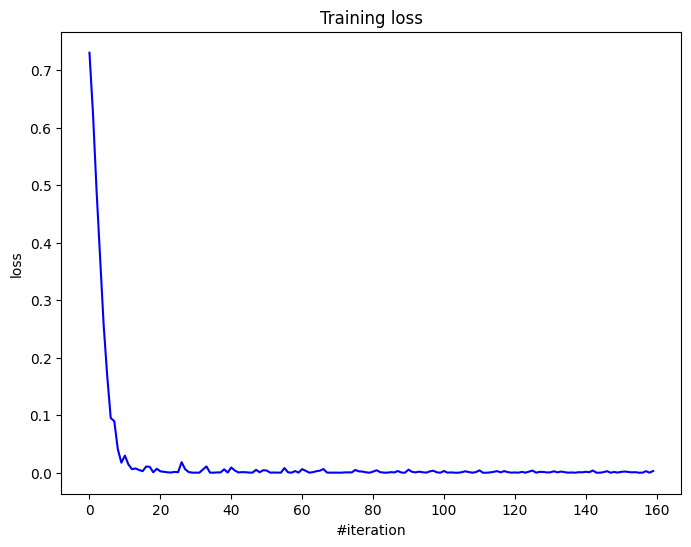

Current loss: 0.003023


In [72]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [73]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [74]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(categories='auto', sparse=False)

y_train = one_hot.fit_transform(y_train.reshape(-1, 1))
y_val = one_hot.fit_transform(y_val.reshape(-1, 1))
# y_test = one_hot.fit_transform(y_test.reshape(-1, 1))
y_train.shape


(50000, 10)

In [75]:
X_train = np.expand_dims(X_train, 1)
X_train = X_train.reshape((X_train.shape[0], -1))
X_train.shape

(50000, 784)

In [76]:
X_val = np.expand_dims(X_val, 1)
X_val = X_val.reshape((X_val.shape[0], -1))
X_val.shape

(10000, 784)

In [77]:
X_test = np.expand_dims(X_test, 1)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test.shape

(10000, 784)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [78]:
# Напишем функцию для тренировки модели

def event_loop(name, net, n_epoch, batch_size, criterion, optimizer, optimmizer_config, optimizer_state):
    loss_history = []
    val_loss_history = []

    for i in range(n_epoch):
        net.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            optimizer(net.getParameters(), 
                        net.getGradParameters(), 
                        optimmizer_config,
                        optimizer_state)      
            
            loss_history.append(loss)
        
            net.evaluate()
            predict = net.forward(X_val)
            val_loss = criterion.forward(predict, y_val)
            val_loss_history.append(val_loss)

            net.train()
        
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(9, 7))
            
        plt.title(f"Training and validation loss {name}")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b', label='train loss')
        plt.plot(val_loss_history, 'r', label='validation loss')
        plt.legend()
        plt.show()
        
        print('Current loss: %f' % loss, 'Current validation loss: %f' % val_loss) 

    return loss_history

In [79]:
losses_two_layers = {}
losses_three_layers = {}

## ReLU

In [80]:
# Построим сначала двухслойную сеть
net_relu_first = Sequential()
net_relu_first.add(Linear(784, 128))
net_relu_first.add(ReLU())
net_relu_first.add(Linear(128, 10))
net_relu_first.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_relu_first)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



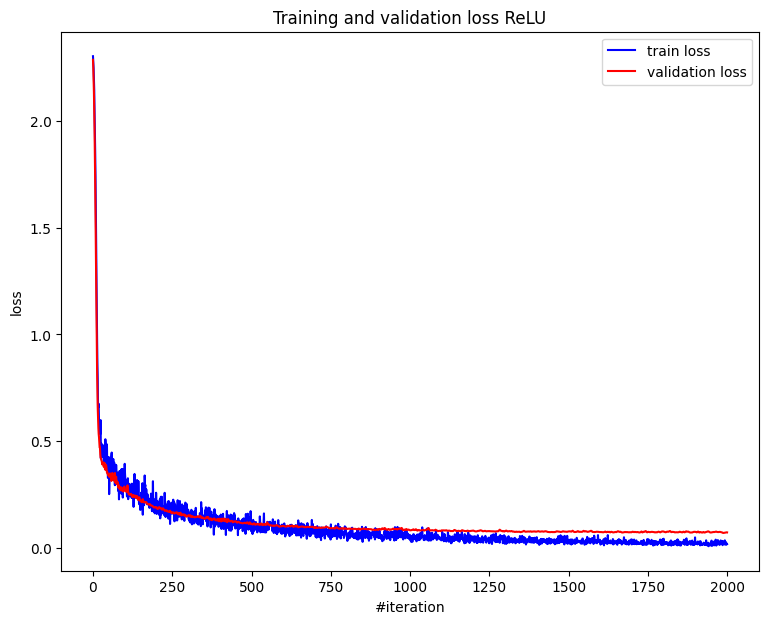

Current loss: 0.019342 Current validation loss: 0.073947


In [81]:
losses = event_loop("ReLU", net_relu_first, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_two_layers["ReLU"] = losses

In [82]:
# Построим трехслойную сеть
net_relu_second = Sequential()
net_relu_second.add(Linear(784, 128))
net_relu_second.add(ReLU())
net_relu_second.add(Linear(128, 64))
net_relu_second.add(ReLU())
net_relu_second.add(Linear(64, 10))
net_relu_second.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_relu_second)

Linear 784 -> 128
ReLU
Linear 128 -> 64
ReLU
Linear 64 -> 10
LogSoftMax



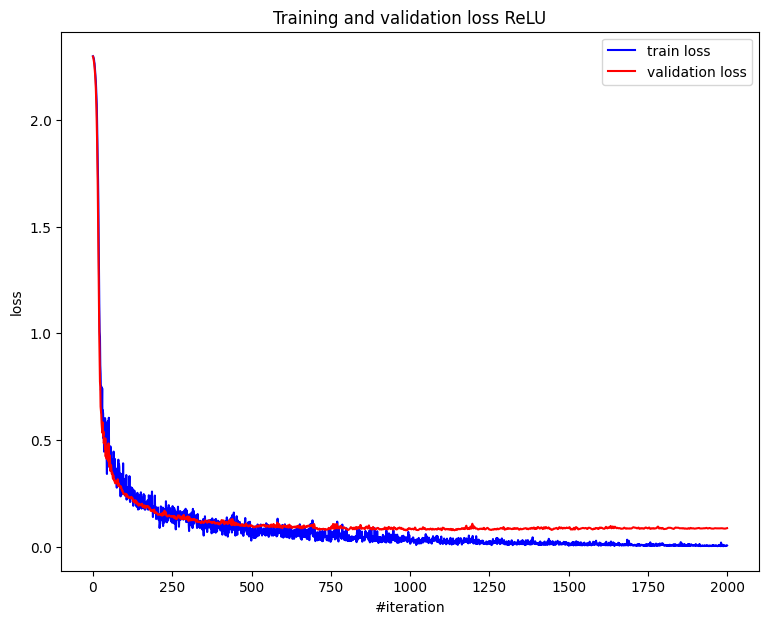

Current loss: 0.004746 Current validation loss: 0.086112


In [83]:
losses = event_loop("ReLU", net_relu_second, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_three_layers["ReLU"] = losses

## ELU

In [84]:
# Построим сначала двухслойную сеть
net_elu_first = Sequential()
net_elu_first.add(Linear(784, 128))
net_elu_first.add(ELU())
net_elu_first.add(Linear(128, 10))
net_elu_first.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_elu_first)

Linear 784 -> 128
ELU
Linear 128 -> 10
LogSoftMax



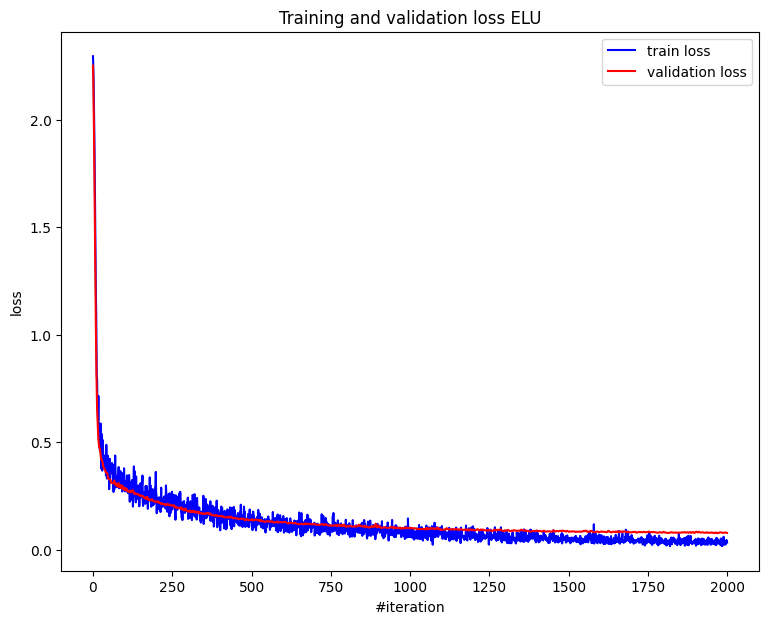

Current loss: 0.032337 Current validation loss: 0.077115


In [85]:
losses = event_loop("ELU", net_elu_first, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_two_layers["ELU"] = losses

In [86]:
# Построим трехслойную сеть
net_elu_second = Sequential()
net_elu_second.add(Linear(784, 128))
net_elu_second.add(ELU())
net_elu_second.add(Linear(128, 64))
net_elu_second.add(ELU())
net_elu_second.add(Linear(64, 10))
net_elu_second.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_elu_second)

Linear 784 -> 128
ELU
Linear 128 -> 64
ELU
Linear 64 -> 10
LogSoftMax



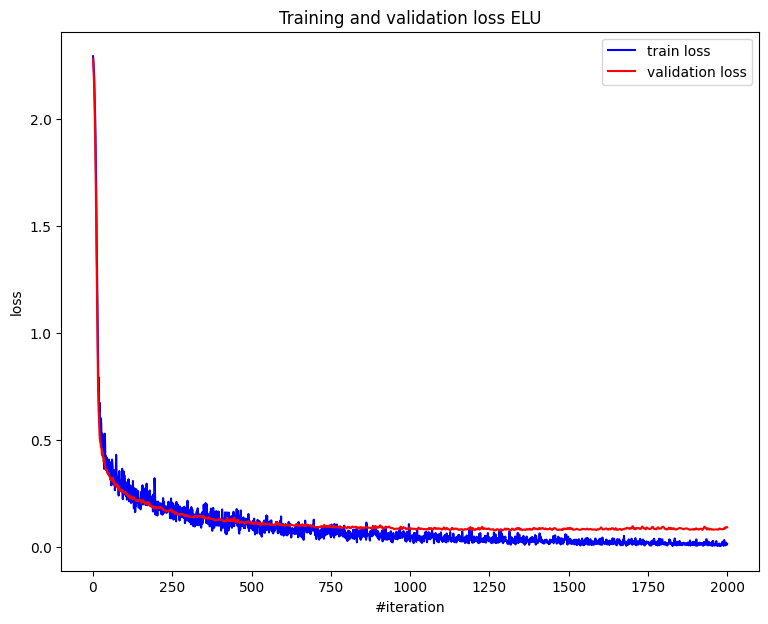

Current loss: 0.015537 Current validation loss: 0.093676


In [87]:
losses = event_loop("ELU", net_elu_second, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_three_layers["ELU"] = losses

## LeakyReLU

In [88]:
# Построим сначала двухслойную сеть
net_leaky_relu_first = Sequential()
net_leaky_relu_first.add(Linear(784, 128))
net_leaky_relu_first.add(LeakyReLU())
net_leaky_relu_first.add(Linear(128, 10))
net_leaky_relu_first.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_leaky_relu_first)

Linear 784 -> 128
LeakyReLU
Linear 128 -> 10
LogSoftMax



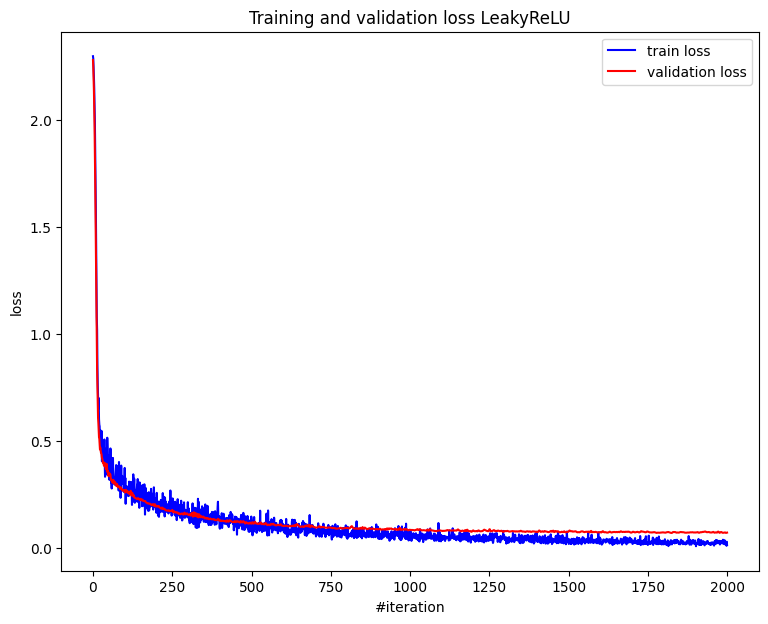

Current loss: 0.013759 Current validation loss: 0.072233


In [89]:
losses = event_loop("LeakyReLU", net_leaky_relu_first, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_two_layers["LeakyReLU"] = losses

In [90]:
# Построим трехслойную сеть
net_leaky_relu_second = Sequential()
net_leaky_relu_second.add(Linear(784, 128))
net_leaky_relu_second.add(LeakyReLU())
net_leaky_relu_second.add(Linear(128, 64))
net_leaky_relu_second.add(LeakyReLU())
net_leaky_relu_second.add(Linear(64, 10))
net_leaky_relu_second.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_leaky_relu_second)

Linear 784 -> 128
LeakyReLU
Linear 128 -> 64
LeakyReLU
Linear 64 -> 10
LogSoftMax



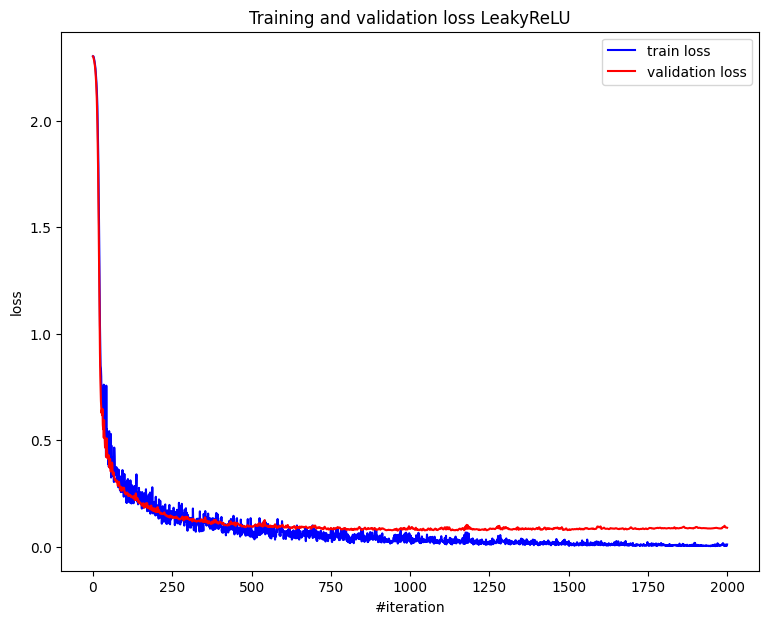

Current loss: 0.009785 Current validation loss: 0.088276


In [91]:
losses = event_loop("LeakyReLU", net_leaky_relu_second, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_three_layers["LeakyReLU"] = losses

## SoftPlus

In [92]:
# Построим сначала двухслойную сеть
net_softplus_first = Sequential()
net_softplus_first.add(Linear(784, 128))
net_softplus_first.add(SoftPlus())
net_softplus_first.add(Linear(128, 10))
net_softplus_first.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_softplus_first)

Linear 784 -> 128
SoftPlus
Linear 128 -> 10
LogSoftMax



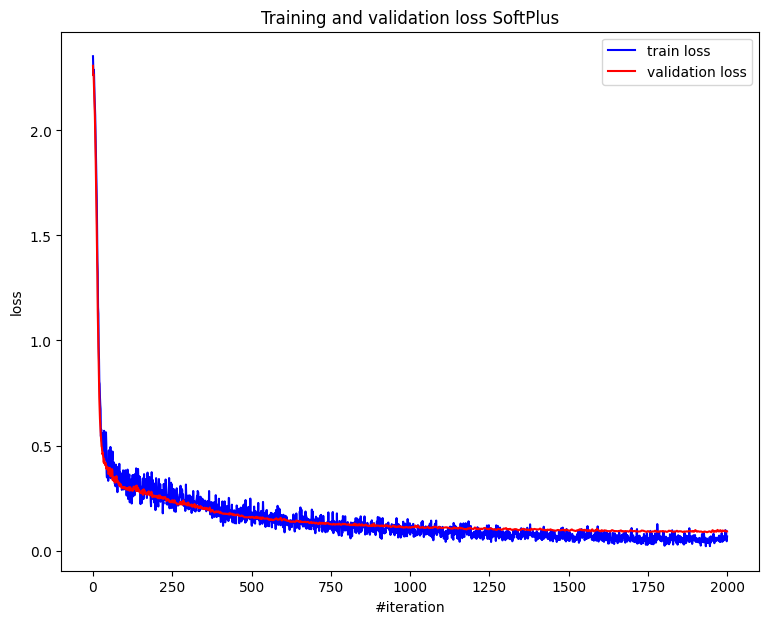

Current loss: 0.066736 Current validation loss: 0.091307


In [93]:
losses = event_loop("SoftPlus", net_softplus_first, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_two_layers["SoftPlus"] = losses

In [94]:
# Построим трехслойную сеть
net_softplus_second = Sequential()
net_softplus_second.add(Linear(784, 128))
net_softplus_second.add(SoftPlus())
net_softplus_second.add(Linear(128, 64))
net_softplus_second.add(SoftPlus())
net_softplus_second.add(Linear(64, 10))
net_softplus_second.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_softplus_second)

Linear 784 -> 128
SoftPlus
Linear 128 -> 64
SoftPlus
Linear 64 -> 10
LogSoftMax



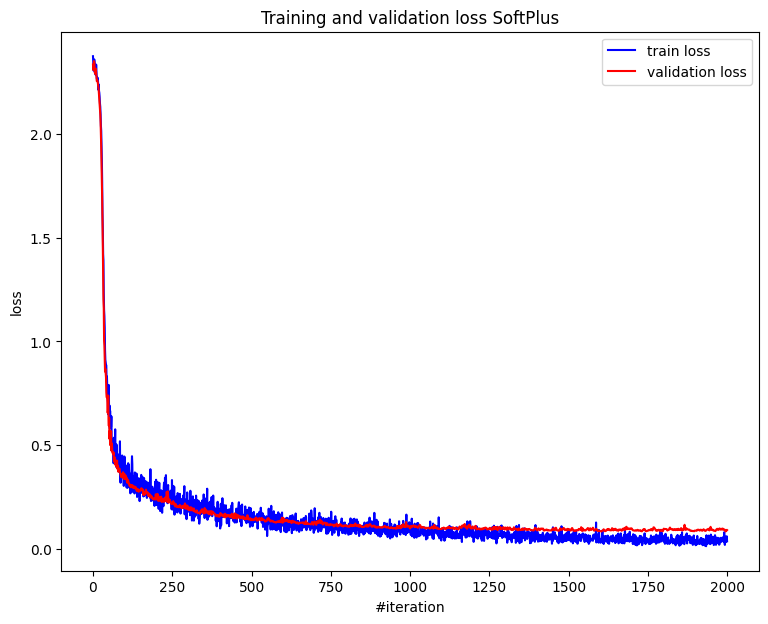

Current loss: 0.036627 Current validation loss: 0.090225


In [95]:
losses = event_loop("SoftPlus", net_softplus_second, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_three_layers["SoftPlus"] = losses

Сравним loss  двуcлойных моделей

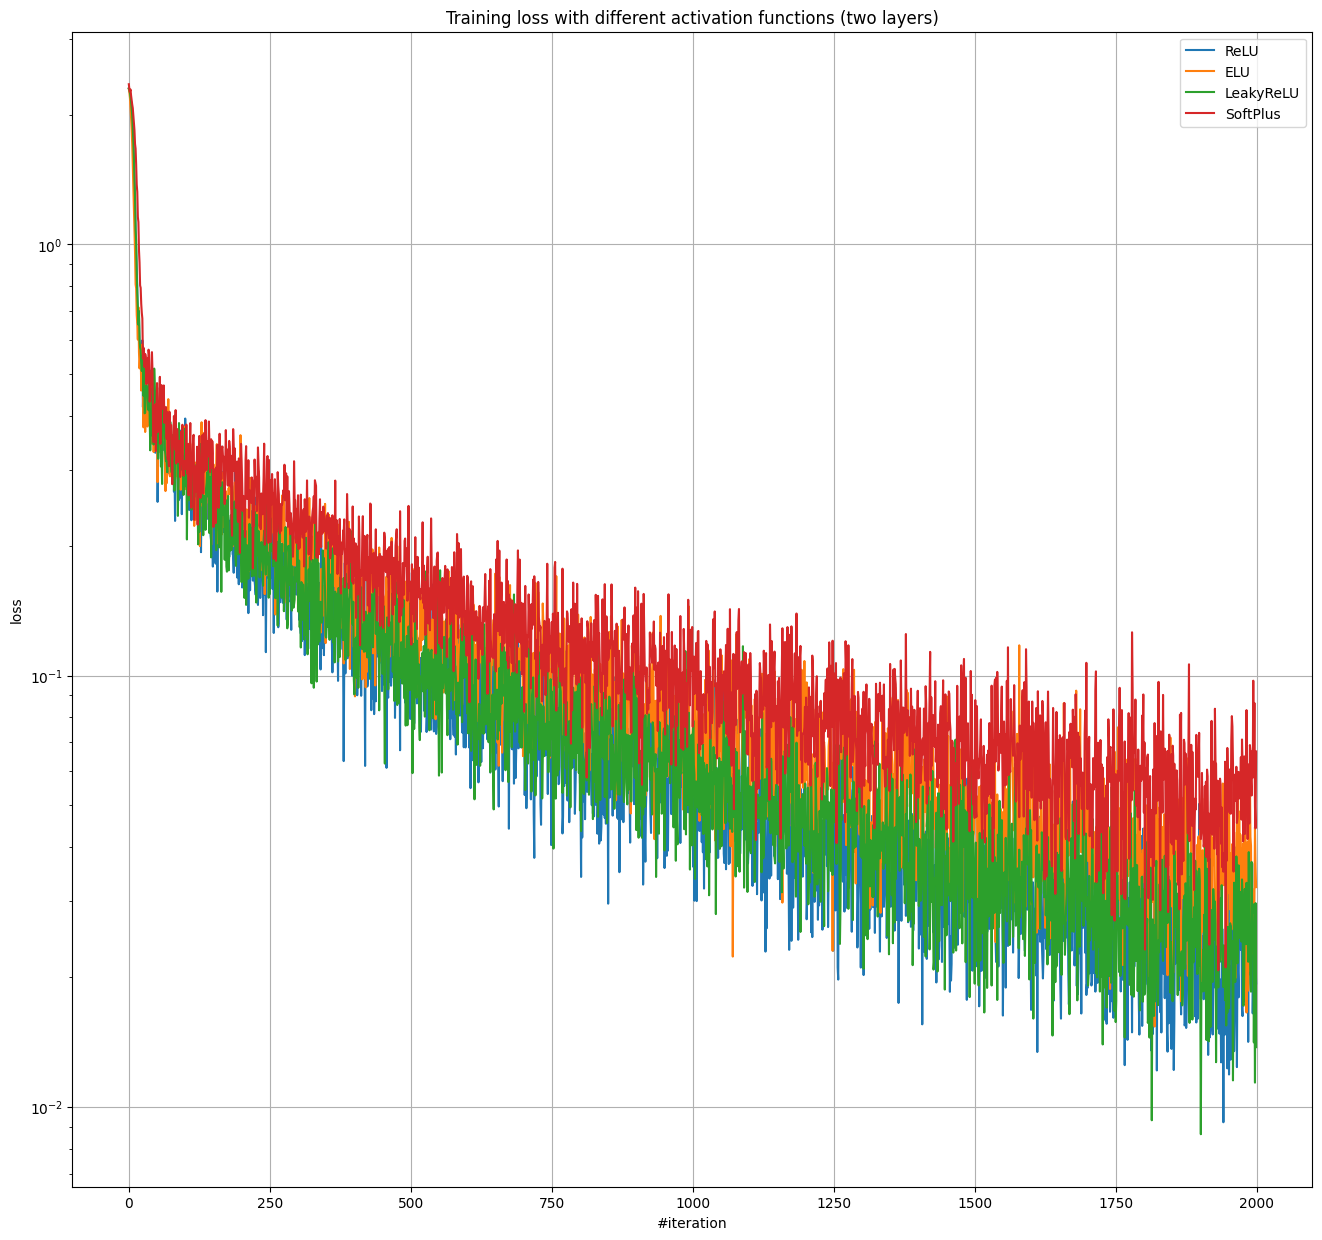

In [96]:
plt.figure(figsize=(16, 15))

for func in losses_two_layers.keys():
    plt.plot(losses_two_layers[func], label=func)
plt.title(f"Training loss with different activation functions (two layers)")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend()
plt.grid(':')
plt.yscale('log')
plt.show()

По графику видно, что выигрывает всегда ReLU и LeakyReLU, которые дают меньший loss на всех итерациях.

Сравним loss трехслойной модели

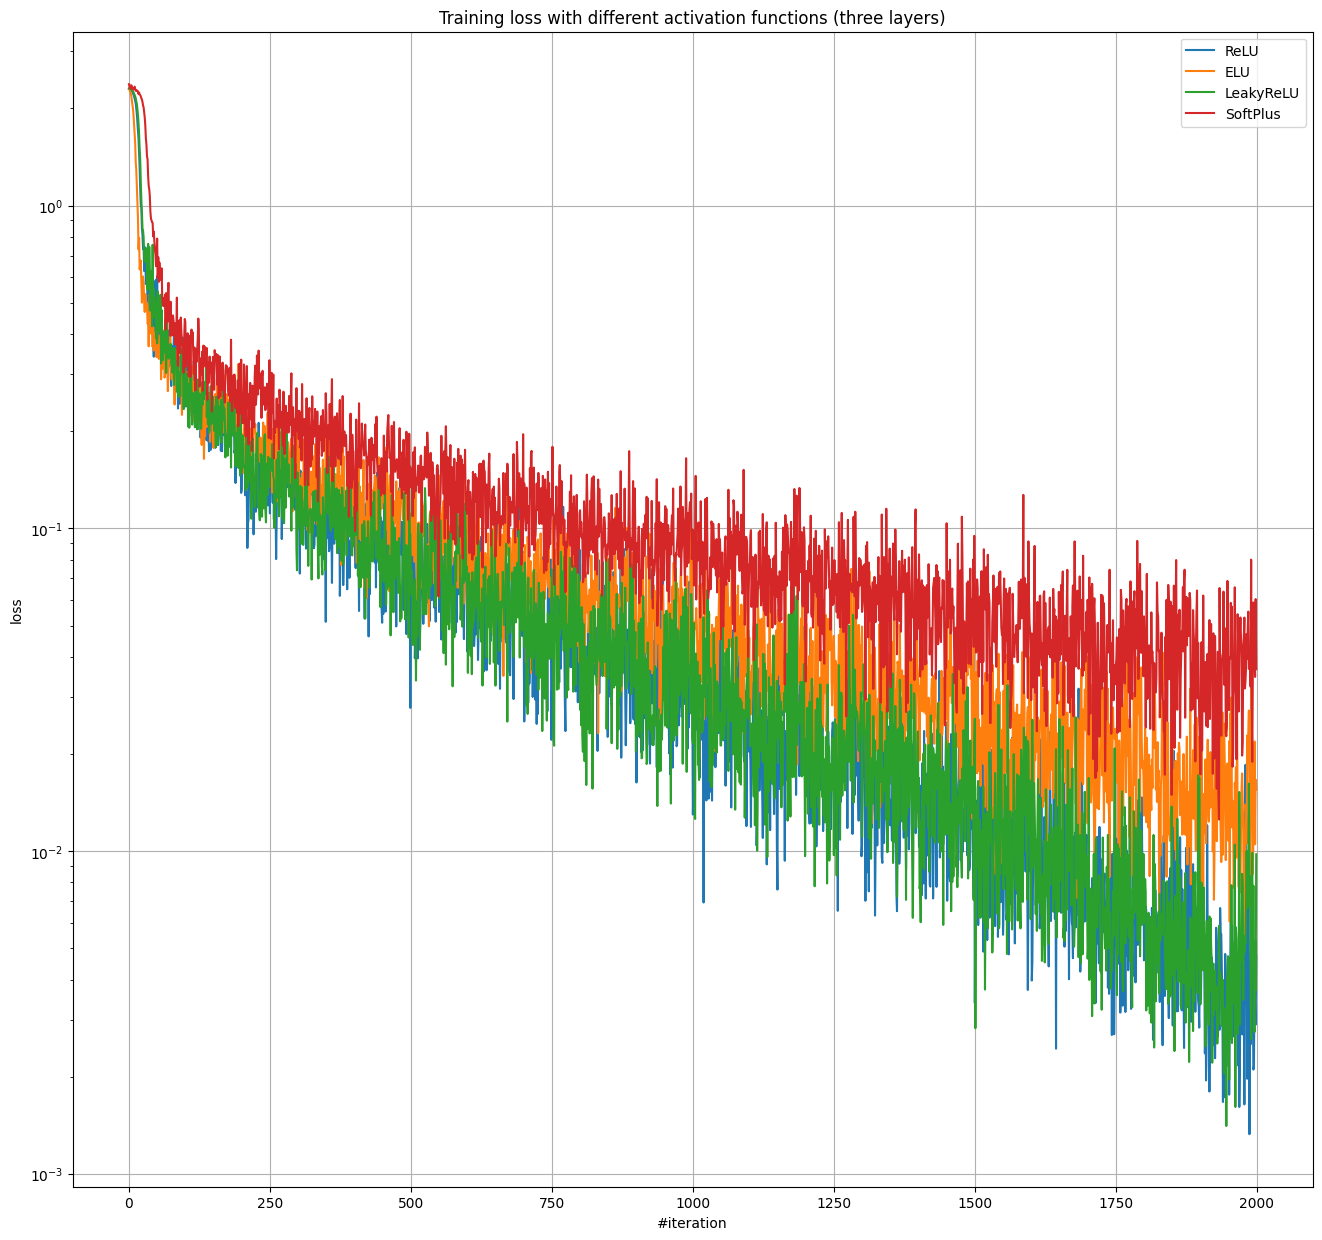

In [97]:
plt.figure(figsize=(16, 15))

for func in losses_three_layers.keys():
    plt.plot(losses_three_layers[func], label=func)
plt.title(f"Training loss with different activation functions (three layers)")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend()
plt.grid(':')
plt.yscale('log')
plt.show()

Хуже всех в обоих случаях показала себя функция активации SoftPlus, а лучше всех были примерно одинаково всегда  ReLU и LeakyReLU. 

## With BatchNormalization

Проверим станет ли лучше только для двух лучший функций активации

In [98]:
net_leaky_relu_batch = Sequential()
net_leaky_relu_batch.add(Linear(784, 128))
net_leaky_relu_batch.add(BatchNormalization(alpha=0.9))
net_leaky_relu_batch.add(ChannelwiseScaling(n_out=128))
net_leaky_relu_batch.add(LeakyReLU())
net_leaky_relu_batch.add(Linear(128, 10))
net_leaky_relu_batch.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_leaky_relu_batch)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 128 -> 10
LogSoftMax



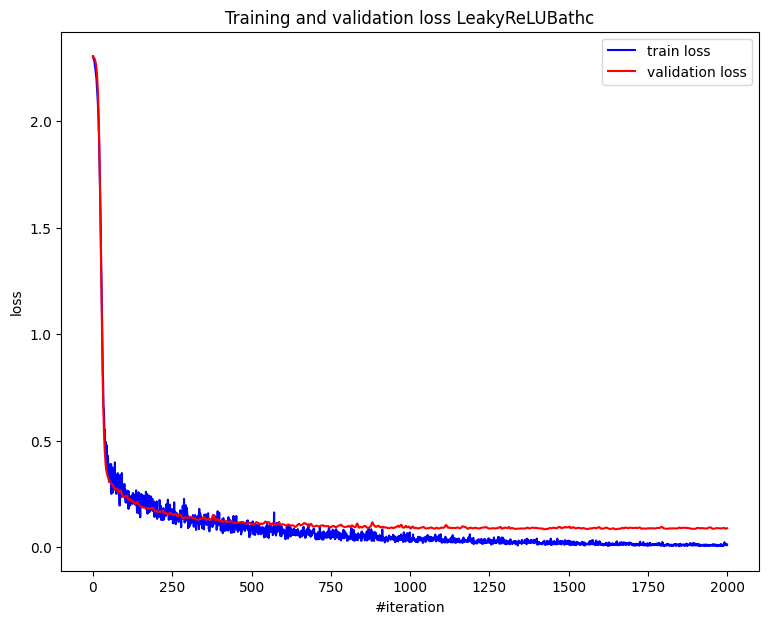

Current loss: 0.013592 Current validation loss: 0.089297


In [99]:
losses = event_loop("LeakyReLUBathc", net_leaky_relu_batch, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_two_layers["LeakyReLUBathc"] = losses

In [100]:
net_relu_batch = Sequential()
net_relu_batch.add(Linear(784, 128))
net_relu_batch.add(BatchNormalization(alpha=0.9))
net_relu_batch.add(ChannelwiseScaling(n_out=128))
net_relu_batch.add(ReLU())
net_relu_batch.add(Linear(128, 10))
net_relu_batch.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_relu_batch)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax



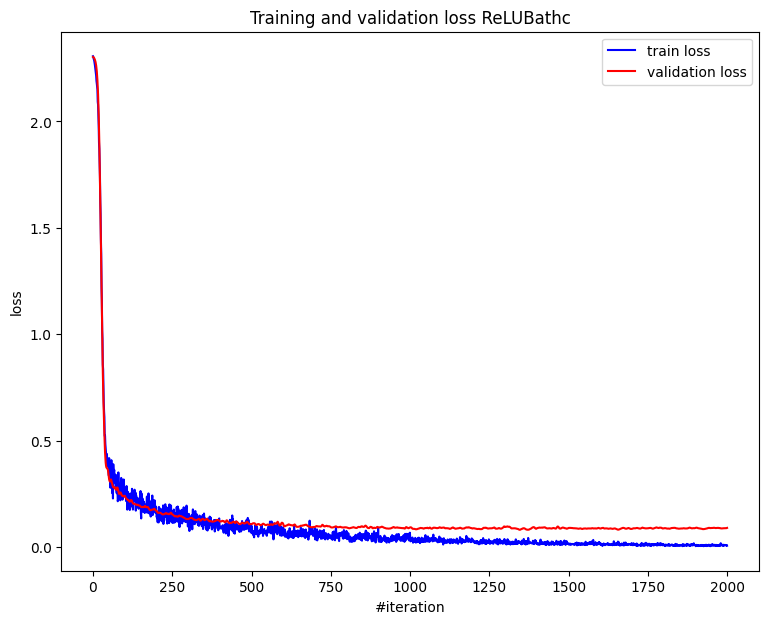

Current loss: 0.007880 Current validation loss: 0.091383


In [101]:
losses = event_loop("ReLUBathc", net_relu_batch, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 1e-1, 'momentum': 0.9}, optimizer_state={})
losses_two_layers["ReLUBathc"] = losses

Сравним:

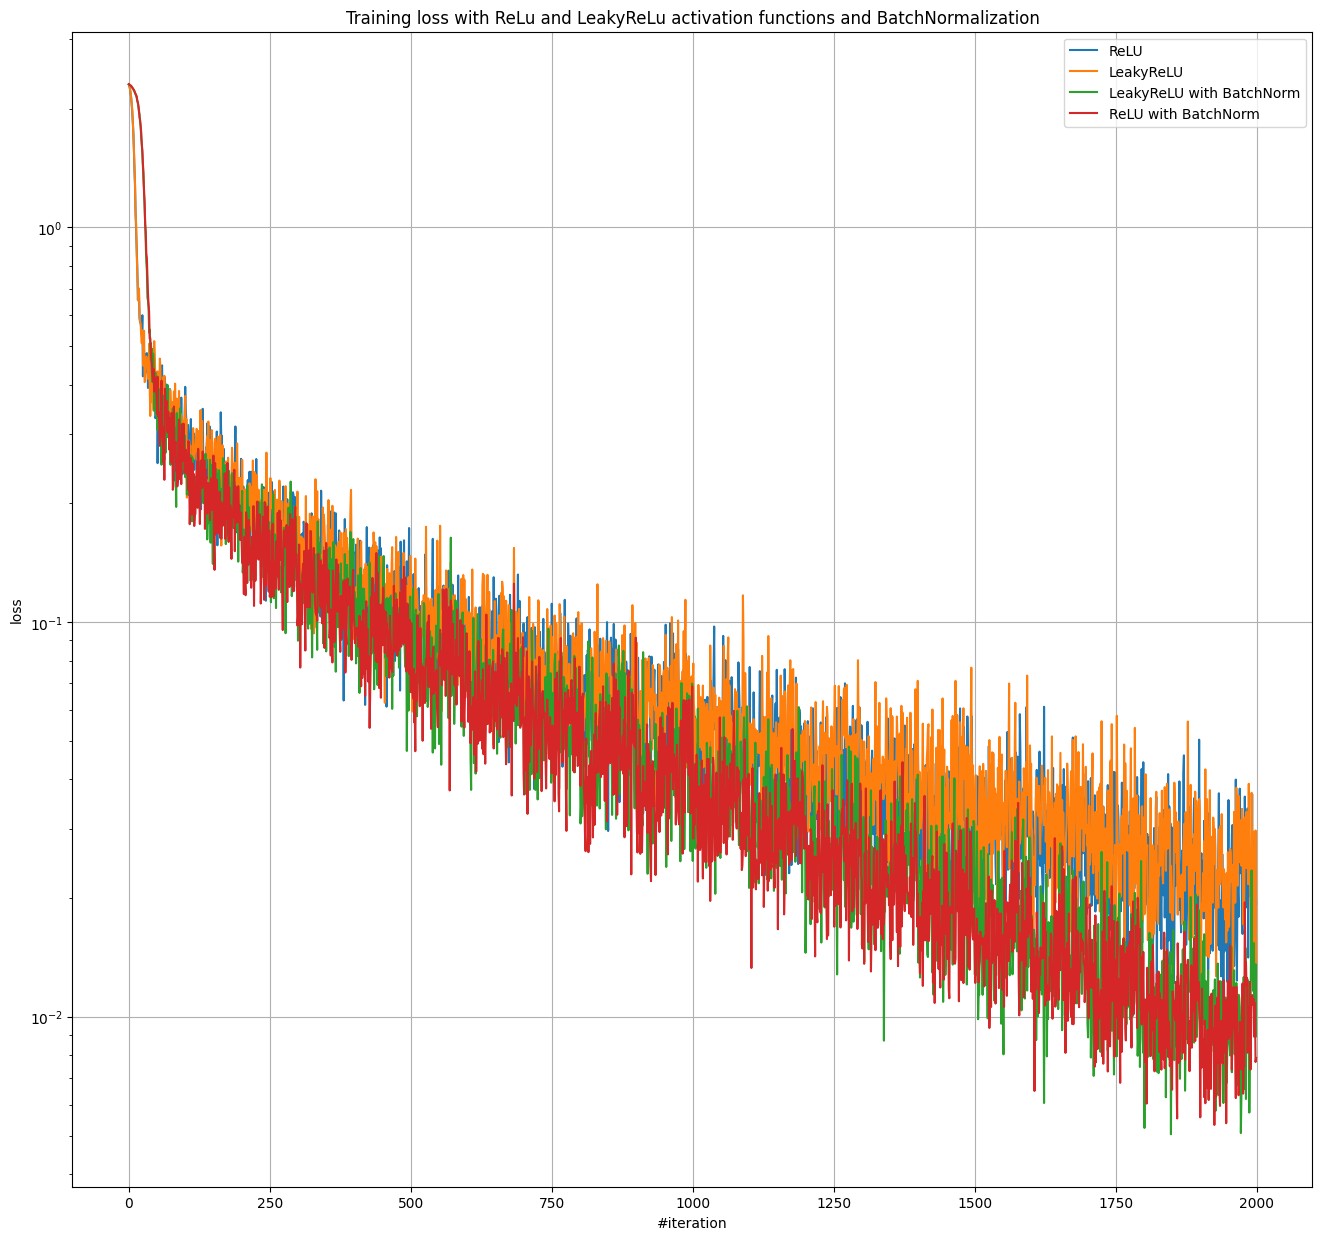

In [102]:
plt.figure(figsize=(16, 15))

plt.plot(losses_two_layers["ReLU"], label="ReLU")
plt.plot(losses_two_layers["LeakyReLU"], label="LeakyReLU")
plt.plot(losses_two_layers["LeakyReLUBathc"], label="LeakyReLU with BatchNorm")
plt.plot(losses_two_layers["ReLUBathc"], label="ReLU with BatchNorm")
plt.title(f"Training loss with ReLu and LeakyReLu activation functions and BatchNormalization")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend()
plt.grid(':')
plt.yscale('log')
plt.show()

По графику видим, что BatchNormalization и правда помогает, loss стал значительно ниже

## Adam Optimizer

Рассмотрим на примере ReLU сильно ли отличаются обычный стохастический спуск и Adam

In [103]:
net_relu_batch_Adam = Sequential()
net_relu_batch_Adam.add(Linear(784, 128))
net_relu_batch_Adam.add(BatchNormalization(alpha=0.9))
net_relu_batch_Adam.add(ChannelwiseScaling(n_out=128))
net_relu_batch_Adam.add(ReLU())
net_relu_batch_Adam.add(Linear(128, 10))
net_relu_batch_Adam.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_relu_batch_Adam)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax



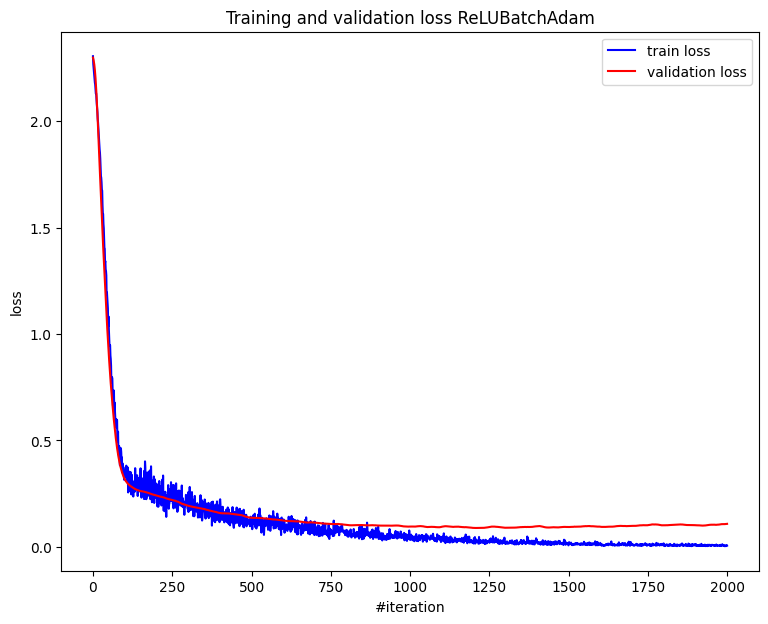

Current loss: 0.005369 Current validation loss: 0.107890


In [104]:
losses = event_loop("ReLUBatchAdam", net_relu_batch_Adam, n_epoch=20, batch_size=500, criterion=criterion, optimizer=adam_optimizer,
                                optimmizer_config={'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5}, optimizer_state={})
losses_two_layers["ReLUBatchAdam"] = losses

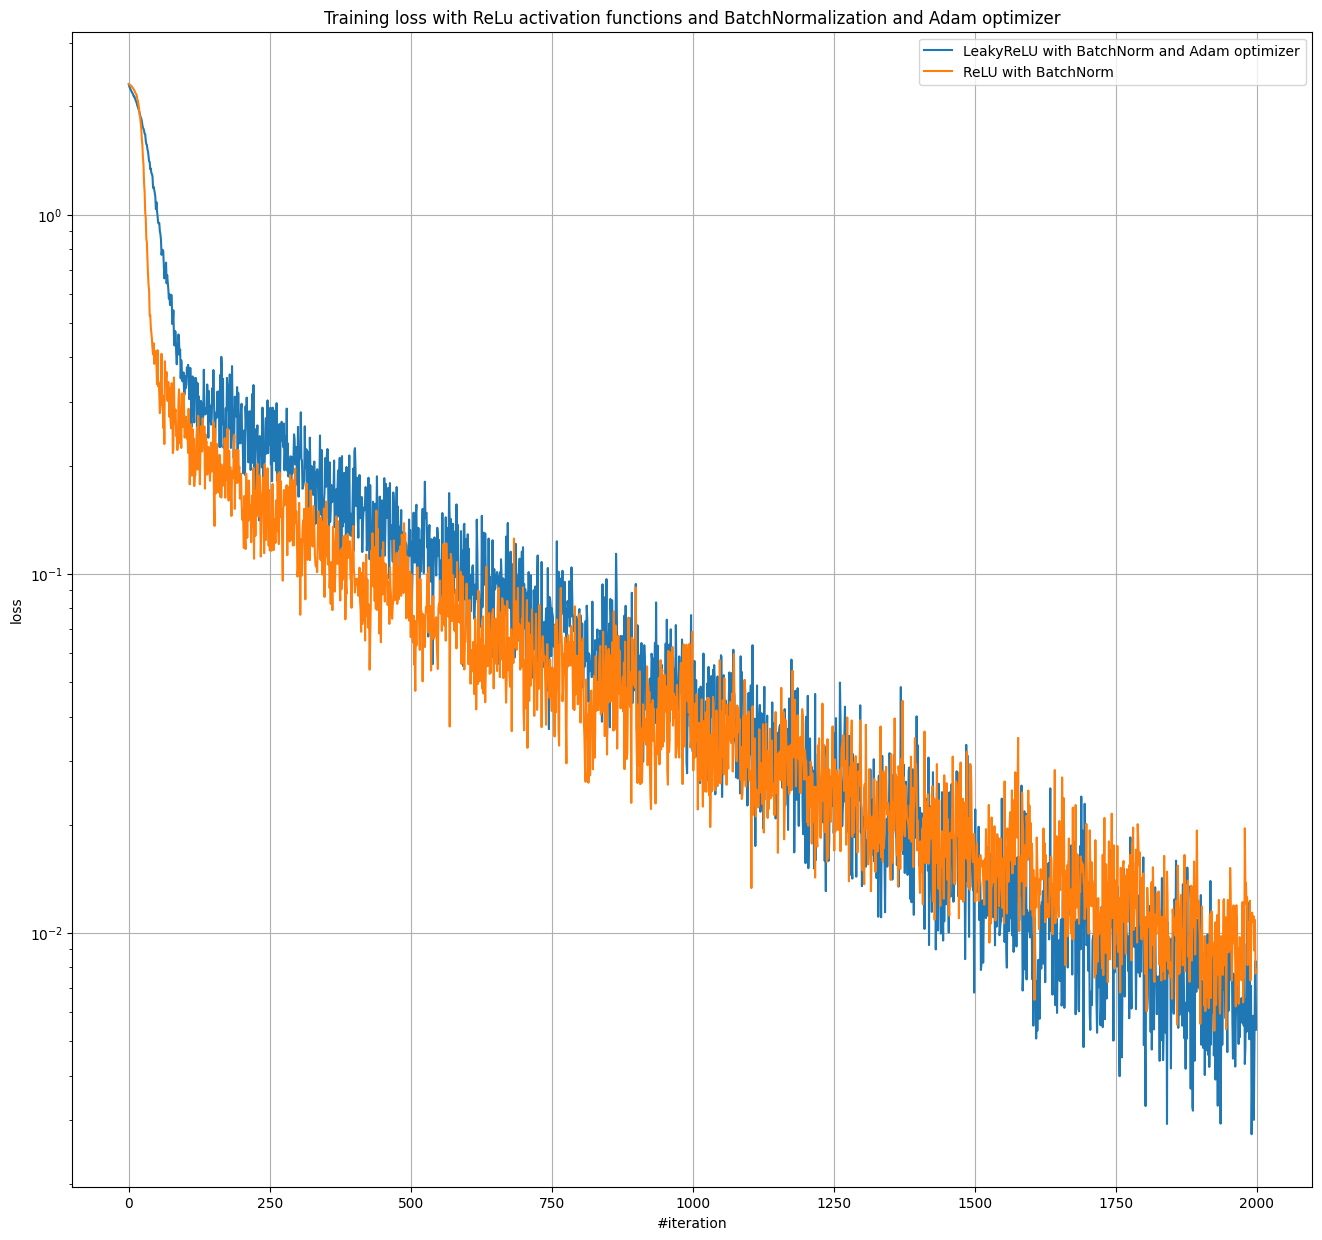

In [105]:
plt.figure(figsize=(16, 15))

plt.plot(losses_two_layers["ReLUBatchAdam"], label="LeakyReLU with BatchNorm and Adam optimizer")
plt.plot(losses_two_layers["ReLUBathc"], label="ReLU with BatchNorm")
plt.title(f"Training loss with ReLu activation functions and BatchNormalization and Adam optimizer")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.legend()
plt.grid(':')
plt.yscale('log')
plt.show()

По графику видно, что оптимизатор Адам реально улучшает результаты

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

BatchNorm однозначно помогает достичь лучшего результата, но вместе с оптимизатором Адам надо подбирать лучше параметры, чтобы появился явный результат.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Попробуем сначала построить ту же сеть что и в прошлом примере, только добавим еще Dropout:

In [106]:
net_best = Sequential()
net_best.add(Linear(784, 128))
net_best.add(BatchNormalization(alpha=0.9))
net_best.add(ChannelwiseScaling(n_out=128))
net_best.add(ReLU())
net_best.add(Dropout(p=0.5))
net_best.add(Linear(128, 10))
net_best.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_best)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 10
LogSoftMax



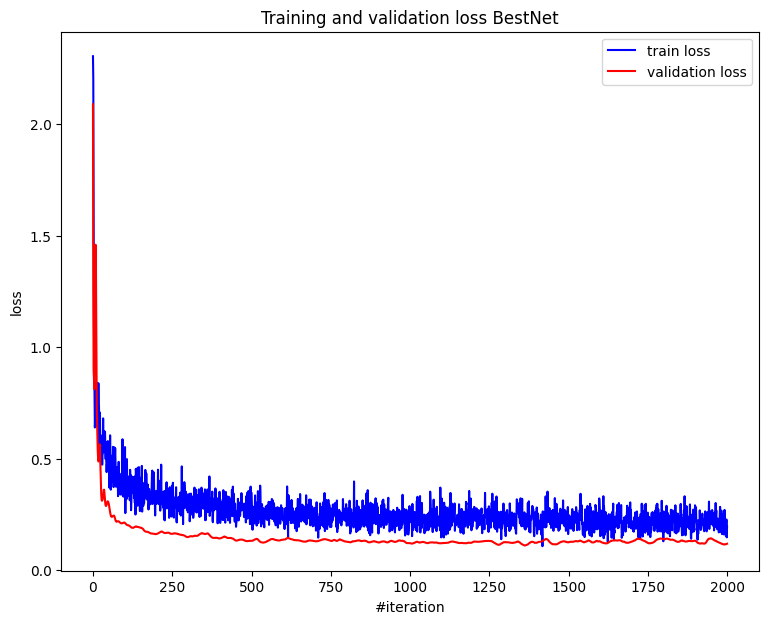

Current loss: 0.195866 Current validation loss: 0.118774


In [107]:
from sklearn.metrics import accuracy_score

losses = event_loop("BestNet", net_best, n_epoch=20, batch_size=500, criterion=criterion, optimizer=adam_optimizer,
                                optimmizer_config={'learning_rate' : 1e-1, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5}, optimizer_state={})

# Протестируем нашу сеть
net_best.evaluate()
predictions = net_best.forward(X_test)
y_result = np.argmax(predictions, axis=1)
accuracy_first = accuracy_score(y_result, y_test)

 Теперь попробуем изменить некоторые параметры, например будем использовать sgd оптимизатор и добавим еще один слой активизации

In [108]:
net_best2 = Sequential()
net_best2.add(Linear(784, 128))
net_best2.add(BatchNormalization(alpha=0.9))
net_best2.add(ChannelwiseScaling(n_out=128))
net_best2.add(ReLU())
net_best2.add(Dropout(p=0.5))
net_best2.add(Linear(128, 64))
net_best2.add(BatchNormalization(alpha=0.9))
net_best2.add(ChannelwiseScaling(n_out=64))
net_best2.add(ReLU())
net_best2.add(Linear(64, 10))
net_best2.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_best2)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 128 -> 64
BatchNormalization
ChannelwiseScaling
ReLU
Linear 64 -> 10
LogSoftMax



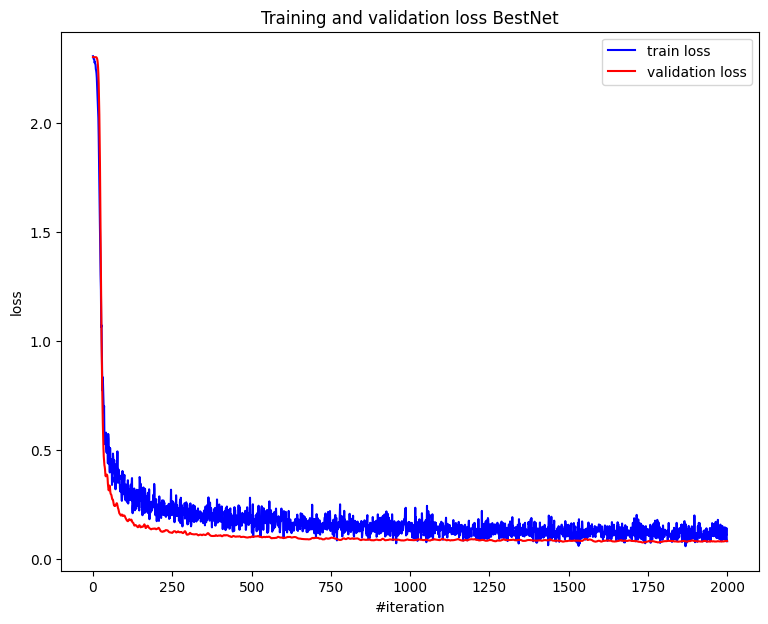

Current loss: 0.081839 Current validation loss: 0.083027


In [109]:
from sklearn.metrics import accuracy_score

losses = event_loop("BestNet", net_best2, n_epoch=20, batch_size=500, criterion=criterion, optimizer=sgd_momentum,
                                optimmizer_config={'learning_rate': 2e-1, 'momentum': 0.9}, optimizer_state={})

# Протестируем нашу сеть
net_best2.evaluate()
predictions = net_best2.forward(X_test)
y_result = np.argmax(predictions, axis=1)
accuracy_second = accuracy_score(y_result, y_test)

Print here your accuracy on test set. It should be around 90%.

In [110]:
print(f'Accuracy score of first model on test:{accuracy_first}')
print(f'Accuracy score of second model on test:{accuracy_second}')

Accuracy score of first model on test:0.968
Accuracy score of second model on test:0.9751


Вторая можель показала чуть лучшие результаты, но работала намного дольше, там что в дальнейшем будем исользовать первую модель

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [111]:
import torch
from torch import nn

net_torch = nn.Sequential()
net_torch.add_module("Linear_first", nn.Linear(784, 128))
net_torch.add_module("BatchNorm", nn.BatchNorm1d(128, eps=1e-3, momentum=1-0.9))
net_torch.add_module("ReLU", nn.ReLU())
net_torch.add_module("Dropout", nn.Dropout(p=0.5))
net_torch.add_module("Linear_second", nn.Linear(128, 10))
net_torch.add_module("LogSoftMax", nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

print(net_torch)

Sequential(
  (Linear_first): Linear(in_features=784, out_features=128, bias=True)
  (BatchNorm): BatchNorm1d(128, eps=0.001, momentum=0.09999999999999998, affine=True, track_running_stats=True)
  (ReLU): ReLU()
  (Dropout): Dropout(p=0.5, inplace=False)
  (Linear_second): Linear(in_features=128, out_features=10, bias=True)
  (LogSoftMax): LogSoftmax(dim=1)
)


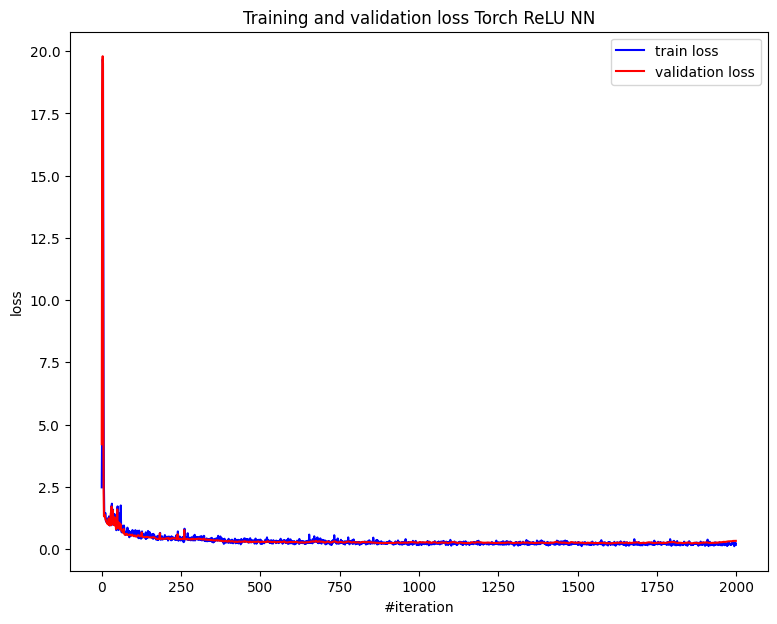

Current loss: 0.164827 Current validation loss: 0.326527


In [112]:
optimizer = torch.optim.Adam(net_torch.parameters(), lr=1e-1, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 20
batch_size = 500
optimizer_state = {}
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

loss_history = []
val_loss_history = []

for i in range(n_epoch):
    net.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        x_batch = torch.FloatTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
            
        # Forward
        predictions = net_torch.forward(x_batch)
        loss = criterion(predictions, y_batch.argmax(axis=1))
        
        # Backward
        dp = criterion(predictions, y_batch.argmax(axis=1))
        
        dp.backward()
        optimizer.step()
        optimizer.zero_grad() 
            
        loss_history.append(loss.detach().numpy())
        
        net_torch.eval()
        predict = net_torch.forward(X_val)
        val_loss = criterion(predict, y_val.argmax(axis=1))
        val_loss_history.append(val_loss.detach().numpy())

        net.train()
        
        # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(9, 7))
            
    plt.title(f"Training and validation loss Torch ReLU NN")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b', label='train loss')
    plt.plot(val_loss_history, 'r', label='validation loss')
    plt.legend()
    plt.show()
        
    print('Current loss: %f' % loss, 'Current validation loss: %f' % val_loss) 


In [113]:
net_torch.eval()
predictions = net_torch.forward(torch.FloatTensor(X_test))
y_pred = predictions.argmax(axis=1)
print(f'Accuracy score of torch NN model on test:{accuracy_score(y_pred, y_test)}')

Accuracy score of torch NN model on test:0.9347


Модель на рукописном торче даже обучилась на 0.01 лучше ). Но понятно, что в целом мы построили свою правильную аналогию PyTorch